<a href="https://colab.research.google.com/github/MaLuWi/guayas_store_project/blob/main/Time_Series_Project_Masterschool_filtering_for_Guayas_region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/Time Series/train.csv', nrows=2e6)
df_stores = pd.read_csv('/content/drive/MyDrive/Time Series/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Time Series/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Time Series/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/Time Series/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Time Series/holidays_events.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Filtering the Data for the Guayas region and the top three familys**

In [ ]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/Time Series/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-2-76d42c2d7c8f>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/Time Series/train.csv', chunksize=chunk_size):


In [ ]:
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families
top_3_families

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


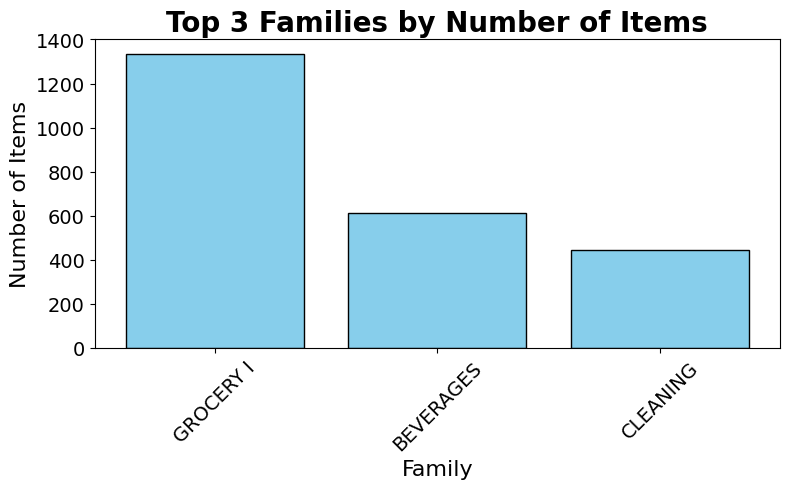

In [ ]:
# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

In [ ]:
df_train.shape #From around 22.9 millions of rows to around 14.7

(14745768, 6)

In [ ]:
df_train.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN
6,18795,2013-01-02,24,105857,1.0,NaN
7,18796,2013-01-02,24,106716,3.0,NaN
10,18799,2013-01-02,24,108786,3.0,NaN
11,18800,2013-01-02,24,108797,2.0,NaN
13,18802,2013-01-02,24,108862,3.0,NaN


In [ ]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
#I want to compare the shape of df_items to the df_items contained in the new df_train -
#but filtering seems obsolete given the small file size (in comparison to the train set)
filtered_item_ids = df_train['item_nbr'].unique()
df_items2 = df_items[df_items['item_nbr'].isin(filtered_item_ids)]

In [ ]:
df_items.shape

(4100, 4)

In [ ]:
df_items2.shape

(2323, 4)

In [ ]:
#check how many items from top 3 are missing in the filtered set
filtered_counts = df_items2['family'].value_counts().reset_index()
filtered_counts.columns = ['Family', 'Item Count Filtered']

#Merge top_3_families from earlier with the filtered_counts
comparison = pd.merge(top_3_families, filtered_counts, on='Family', how='left')

# Rename full count column
comparison = comparison.rename(columns={'Item Count': 'Item Count Full'})
comparison #we see small differences in the number of items: not for sale in guayas

,Family,Item Count Full,Item Count Filtered
0,GROCERY I,1334,1277
1,BEVERAGES,613,602
2,CLEANING,446,444


Next steps

->Data Exploration

->Find out if there are any missing values and eliminate them. As for the missing dates, fill them up with zero sales.

->Handle outliers in unit_sales if there are any.

->Engineer features similar to what we did in the in this theory of this sprint
Save the prepared dataset as a .csv file to your google drive. During the next weeks, will get back to this data!

EDA for the region of our interest ("Guayas")
Conduct an exploratory data analysis (EDA). Find out the answers for the questions that are similar to what found answers for the "Pichincha" region but now for the "Guayas" region.
Feel free to examine the data even further! It would enrich your project and lead you to better data understanding.

# **EDA and Datacleaning**

In [ ]:
df_train.info() #in large datasets pandas skips counting non-null values to save time and memory
#Pandas automatically set onpromotion to 'object' because it contained: "False", "True", NaN - and could not understand if it's a bool or string

<class 'pandas.core.frame.DataFrame'>
Index: 14745768 entries, 1 to 22941654
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 787.5+ MB


In [ ]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,2747275


In [ ]:
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool) #first to bool.
df_train['onpromotion'] = df_train['onpromotion'].astype(int) #ML models work best with numbers
df_train.head()

<ipython-input-15-f91c80285812>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool) #first to bool.


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,0
2,18791,2013-01-02,24,105575,2.0,0
3,18792,2013-01-02,24,105577,1.0,0
4,18793,2013-01-02,24,105693,7.0,0
5,18794,2013-01-02,24,105737,17.0,0


In [ ]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [ ]:
#Checking for negative sales which indicate product returns.
negative_sales = df_train[df_train['unit_sales'] < 0]
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,0
54236,309805,2013-01-09,35,1079215,-8.0,0
64452,382905,2013-01-11,27,1097187,-20.0,0
96414,564108,2013-01-15,51,627885,-36.0,0
132903,787522,2013-01-21,24,211205,-5.0,0


In [ ]:
negative_sales.shape

(794, 6)

In [ ]:
#Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [ ]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

In [ ]:
# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

<ipython-input-21-faa2e1e437f8>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


In [ ]:
# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()
#There are many of these values but they don't look like errors. These are just big sales.

Number of outliers detected: 48485


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,0,7.946399
286,59775862,2015-10-20,24,99197,14.0,0,5.822016
289,60322807,2015-10-26,24,99197,19.0,0,8.276173
721,15717753,2013-12-19,24,103520,27.0,0,6.642670
770,18886543,2014-02-13,24,103520,22.0,0,5.154400


In [ ]:
outliers.shape

(48485, 7)

In [ ]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


In [ ]:
#Ok, now we have a list of all dates between the min and max date in our dataset! Next, let's create a DataFrame with all (store, item, date) combinations
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates() #This gives a DataFrame of all unique store-item pairs in df_train
all_combinations = store_item_combinations.merge(full_date_range, how='cross') #This creates a Cartesian product: Every store-item pair × every date in the range
all_combinations
# Why are we doing this?
#Because for time series forecasting, you need a complete time-indexed dataset, even for days with no sales.
#This allows you to:
#->Fill missing dates
#->Set zero sales on dates with no transactions
#->Handle seasonality and lags correctly

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


In [ ]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left') # Any missing sales will show as NaN in the unit_sales column after this.

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0) #If a store-item-date combo had no recorded sale, this sets the value to zero.

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train = df_filled
del df_filled

In [ ]:
#Feature engineering
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [ ]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [ ]:
df_train.head(10) #Look, for the first days we have no values in the 'unit_sales_7d_avg' column. This is because we used the window size that is equal to 7

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,0.0,2013,1,2,2,NaN
1,24,105574,2013-01-03,59692.0,1.0,0.0,2013,1,3,3,NaN
2,24,105574,2013-01-04,99664.0,3.0,0.0,2013,1,4,4,NaN
3,24,105574,2013-01-05,140805.0,4.0,0.0,2013,1,5,5,NaN
4,24,105574,2013-01-06,182800.0,7.0,0.0,2013,1,6,6,NaN
5,24,105574,2013-01-07,223895.0,3.0,0.0,2013,1,7,0,NaN
6,24,105574,2013-01-08,263107.0,3.0,0.0,2013,1,8,1,4.714286
7,24,105574,2013-01-09,302232.0,7.0,0.0,2013,1,9,2,4.000000
8,24,105574,2013-01-10,341031.0,3.0,0.0,2013,1,10,3,4.285714
9,24,105574,2013-01-11,379570.0,6.0,0.0,2013,1,11,4,4.714286


In [ ]:
#Lag Features for sales 1, 7, and 28 days ago
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
df_train['lag_28'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(28)

In [ ]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_28
0,24,105574,2013-01-02,18790.0,12.0,0.0,2013,1,2,2,NaN,NaN,NaN,NaN
1,24,105574,2013-01-03,59692.0,1.0,0.0,2013,1,3,3,NaN,12.0,NaN,NaN
2,24,105574,2013-01-04,99664.0,3.0,0.0,2013,1,4,4,NaN,1.0,NaN,NaN
3,24,105574,2013-01-05,140805.0,4.0,0.0,2013,1,5,5,NaN,3.0,NaN,NaN
4,24,105574,2013-01-06,182800.0,7.0,0.0,2013,1,6,6,NaN,4.0,NaN,NaN


In [ ]:
df_train.to_csv('/content/drive/MyDrive/Time Series/df_train_filtered.csv', index=False)

# **Testing some other stuff for reduction of size**

In [ ]:
df_train.to_parquet(
    "/content/drive/MyDrive/Time Series/df_train_filtered.parquet",
    index=False,
    compression="snappy"
)

In [ ]:
# If unit_sales only ever contains integers between 0 and ~32,767,
# downcast from int64 → int32 (or even int16) automatically:
df_train["unit_sales"] = pd.to_numeric(
    df_train["unit_sales"],
    downcast="integer"
)

In [ ]:
# Only if you want the memory & speed gains:
df_train["store_nbr"] = df_train["store_nbr"].astype("category")
df_train["item_nbr"]  = df_train["item_nbr"].astype("category")

In [ ]:
df_train.to_csv('/content/drive/MyDrive/Time Series/df_train_filtered2.csv', index=False)